<h1><center>k-means</center></h1>

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_blobs, make_circles, load_breast_cancer
from sklearn.preprocessing import StandardScaler
from PIL import Image
from kmeans import * 

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
%run kmeans

This document contains information about exploration of k-means algorightm and its improvement. More specifically this information will include the following:

- What is k-means
- Experiments of basic k-means
- Improvement of k-means: k-means++
- Improvement of k-means++: spectral clustering
- How to measure accuracy
- Application of k-means: image compression
- Conclusions

### What is k-means?

From **definition of clustering**, it is a one of unsupervised machine learning method. It refers to a collection of data points aggregated together because of certain similarities. Furthermore, one of the clustering technique is called k-means. **K-means** algorithm identifies k number of centroids, and then allocates every data point to the nearest cluster while keeping the centroids as small as possible. By taking the mean of the data points, it finds the centroid.

Basic k-means algorithm steps are generalized below:
1. Randomly select k data points, which represents the initial group of centroids.
2. Each data point is assigned into the closest cluster.
3. After all the data points are assigned, the positions of the k centroids are recomputed by taking the average of data points in each cluster
4. Steps 2 and 3 are repeated until the average norm of the change (centroids - previous_centroids) is less than the tolerance

The k-means algorithm is based on the two **assumptions**:
1. The center of the cluster is the mean of all the data points belonging to the cluster
2. Each data point has its own cluster center, which is closer than the other centers



### Experiments of basic k-means

#### Experiments 1

We first generate small two dimensional dataset containing four distinct blobs

In [2]:
X_blobs, _ = make_blobs(n_samples=200, centers=4, cluster_std=0.60, random_state=0)

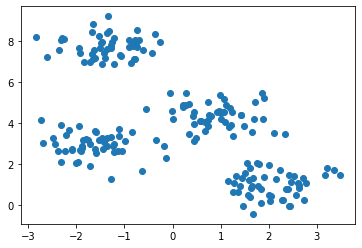

In [3]:
plt.scatter(X_blobs[:, 0], X_blobs[:, 1])
plt.show()

By looking at the dataset, it is easily to divide them into four groups.  
K-means automatically find the group by assigning points to the nearest cluster center and setting the cluster centers to the mean.

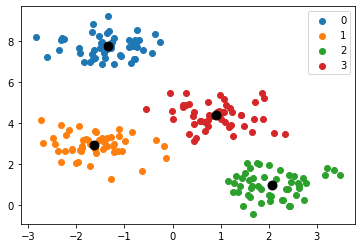

In [4]:
k = 4
centroids, labels = kmeans(X_blobs, k=k, centroids=None, max_iter=30, tolerance=1e-2, seed = 0)
visualize_plot(X_blobs, centroids, labels)

However, there are few challenges from k-means algorithm, 
1. The optimal solution may not be achieved
2. The number of cluster is predetermined
3. k-means cannot handle complicated geometric pattern

#### Experiment 2

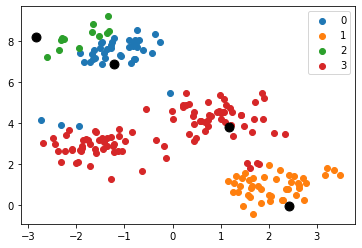

1 iteration


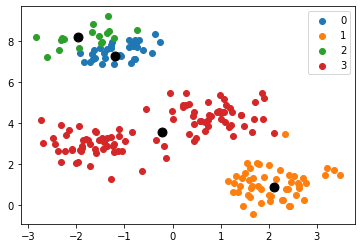

2 iteration


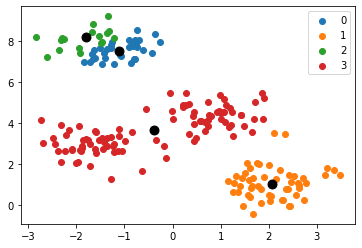

3 iteration


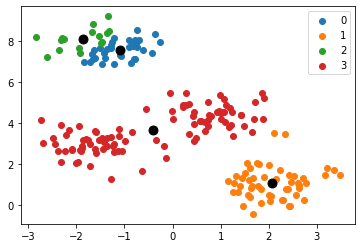

In [5]:
k = 4
centroids, labels = kmeans(X_blobs, k=k, centroids=None, max_iter=30, tolerance=1e-2, visual_plt=True, seed = 6)

Depending on the position of randomly selected initial centroids, there is no guaranteed that it will reach to the optimal solution. As we observed from the above plots, the starting centroids lead to the poor result. 

#### Experiment 3

Another challenge of k-means is it depends on the predetermined k value as it cannot find the number of clusters from the data. For example, k-means are happily take whatever the k value you give and find the optimal solution based on the k.

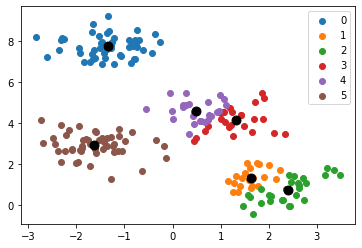

In [6]:
k = 6
centroids, labels = kmeans(X_blobs, k=k, centroids=None, max_iter=30, tolerance=1e-2, seed = 0)
visualize_plot(X_blobs, centroids, labels)

#### Experiment 4

According to the k-means assumption, the boundaries between clusters are always linear. If the boundaries are complicated, then k-means will not be able to find the cluster correctly.

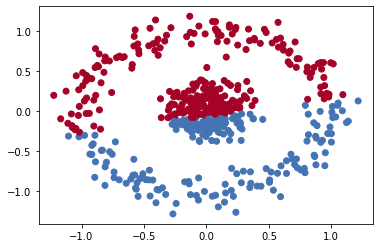

In [7]:
X_circle, _ = make_circles(n_samples=500, noise=0.1, factor=.2)
centroids, labels = kmeans(X_circle, 2)
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X_circle[:,0], X_circle[:,1], c=colors[labels])
plt.show()

### Improvement of k-means: k-means++

To solve the issue from experiment 2, we improve the basic k-means by using k-means++

K-means++ is designed to improve the centroid initialization for k-means. The basic idea is to randomly select the first of k centroids. Then, pick next k-1 points by selecting points that maximize the minimum distance to all existing cluster centroids. So for each point, compute the minimum distance to each cluster. Among those minimum distances to clusters for each point, find the maximum distance. The associated point is the new centroid.

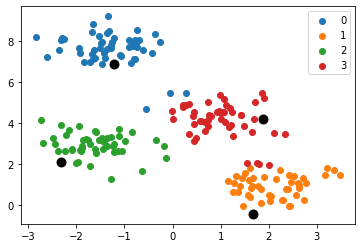

1 iteration


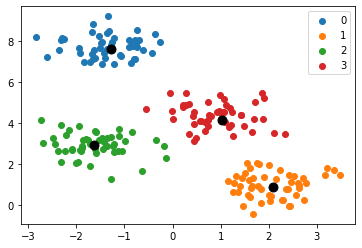

2 iteration


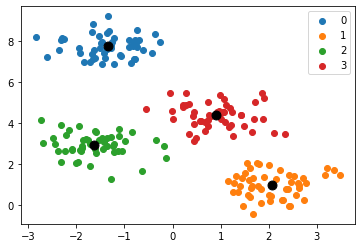

In [8]:
k = 4
centroids, labels = kmeans(X_blobs, k=k, centroids='kmeans++', max_iter=30, tolerance=1e-2, visual_plt=True, seed = 6)

As observed from the above plots, k-means is always tries to select centroids that are far away from the existing centroids, which lead to significant improvement over k-means.

### Improvement of k-means++: spectral clustering

Though k-means++ algorithm is able to solve the problem in experiment 2, it still cannot fix the issue of complicated geometric pattern below.

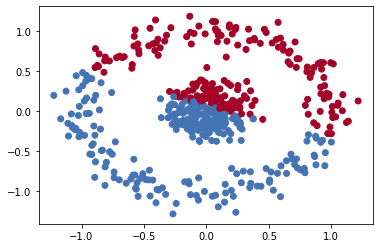

In [9]:
centroids, labels = kmeans(X_circle, k=2, centroids='kmeans++', tolerance=.01, visual_plt=False, seed = 0)
colors=np.array(['#4574B4','#A40227'])
plt.scatter(X_circle[:,0], X_circle[:,1], c=colors[labels])
plt.show()

To solve the issue, we use spectral clustering. It treats each data point as a graph-node and thus transforms the clustering problem into a graph-partitioning problem.

The basic steps is as following:
1. Create the similarity graph in the form of an adjacency matrix A using k-nearest neighbours.
2. Define the degree matrix D, and the graph laplacian matrix which is  L = D - A.
3. Normalize the matrix L.
4. Calculate the eigenvalues and the respective eigenvectors of the matrix L.
5. By using the second smallest eigenvector as input, train a k-means model and use it to classify the data.

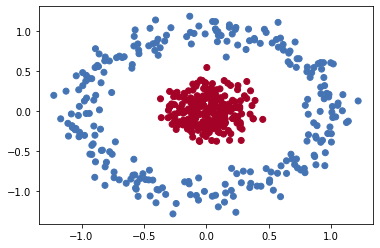

In [10]:
cluster = SpectralClustering(n_clusters=2, affinity="nearest_neighbors")
labels = cluster.fit_predict(X_circle)

colors=np.array(['#4574B4','#A40227'])
plt.scatter(X_circle[:,0], X_circle[:,1], c=colors[labels])
plt.show()

### How to measure accuracy?

Though k-means is unsupervised machine learning algorithm, we are interested in the performance of the model. To measure its performance, we will use the accuracy metric since it's classification problem.

In the following example, as we have the actual labels, we can compare them with the obtained labels and generate confusion matrix. But the challenge is how we know which centroid is associated with which true label (we don't have the y target to work with during clustering). 

To solve the issue, the basic idea is as following: 
1. Find the most common prediction using the actual cluster.
2. Assign each element in that predicted cluster to the appropriate label in the actual cluster.
3. Compare those predicted results to the actual labels.

In [11]:
cancer = load_breast_cancer()
X_cancer = cancer.data
y_cancer = cancer.target

In [12]:
sc = StandardScaler()
X_cancer = sc.fit_transform(X_cancer)

In [13]:
centroids, labels = kmeans(X_cancer, k=2, centroids='kmeans++', tolerance=.01, visual_plt=False, seed = 0)

clustering accuracy:  0.9121265377855887


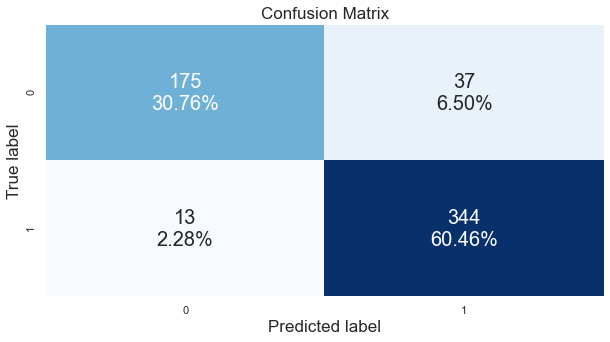

In [14]:
likely_confusion_matrix(y_cancer, labels)

### Application of k-means: image compression

An image is made up of pixels, which represented by integer values (grayscale) or RGB vectors having red intensity value, blue intensity and green intensity value (color). 

K-means clustering will group similar colors together into k clusters of different colors. Therefore,  each cluster centroid will replace all the RGB vectors in their respective cluster.

#### Grayscale Image

After applying k-means++ with k = 4, we are able to reconstruct the grayscale image to have 4 colors only.

In [15]:
img = Image.open('north-africa-1940s-grey.png')
img_height = img.height
img_width = img.width
X_grayscale = np.array(img).flatten().astype(float).reshape(-1, 1)

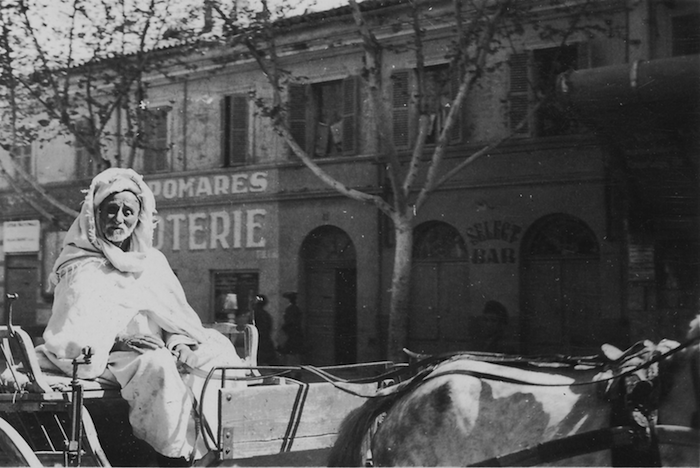

In [16]:
img

In [17]:
k=4

centroids, labels = kmeans(X_grayscale, k=k, centroids='kmeans++', tolerance=.01, seed = 0)
centroids = centroids.astype(np.uint8)
X_grayscale = centroids[labels] # reassign all points

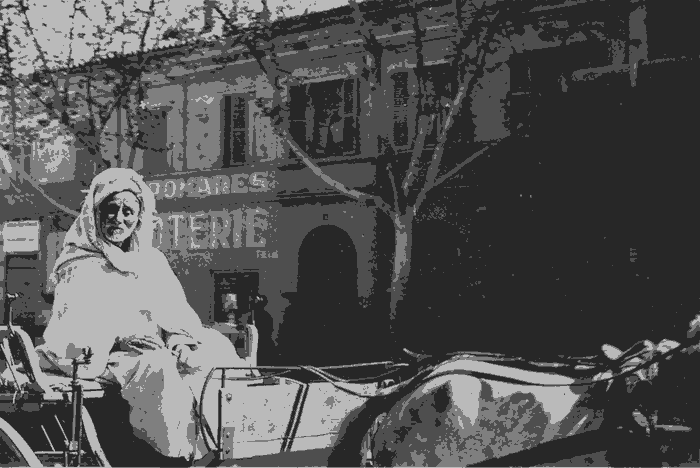

In [18]:
img_ = Image.fromarray(X_grayscale.reshape(img_height,img_width), 'L')
img_

#### Color Image

After applying k-means++ with k = 32, we are able to reconstruct the image to have 32 colors.

In [19]:
img = Image.open('my_portrait.jpg')
img_height = img.height
img_width = img.width
X_color = np.array(img).flatten().astype(float).reshape(-1, 3)

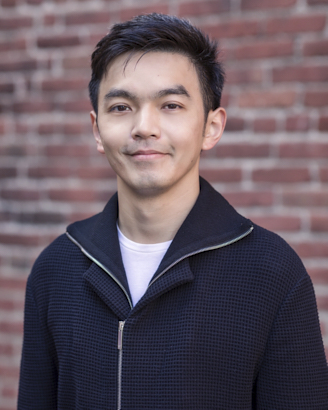

In [20]:
img

In [21]:
k=32
centroids, labels = kmeans(X_color, k=k, centroids='kmeans++', max_iter=30, tolerance=.01, seed = 0)
centroids = centroids.astype(np.uint8)
X_color= centroids[labels] # reassign all points

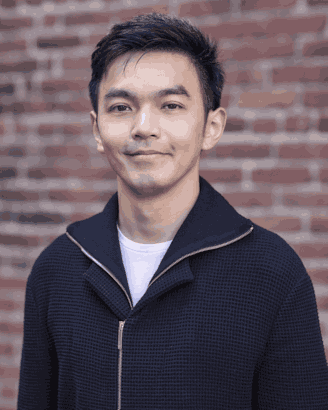

In [22]:
img_ = Image.fromarray(X_color.reshape((img_height,img_width,3)))
img_

### Conclusions

By implementing the experiments, we were able to explore different persepctives of k-means algorithm. 
- k-means clusters data points, but it has limitations, such as predetermined k value and linear boundaries.
- k-means++ improves the k-means algorithm by selecting initial centroids that are far away from the existing centroids
- spectral clustering is better to handle the complicated geometric problem as it treats the data clustering as a graph partitioning problem